In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=9.8023e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, h1, **kwargs):
        super(H2Layer, self).__init__(**kwargs)
        self.h1 = h1

    def call(self, x):
        return (2*x*(self.h1(x)))-2
    
class H3Layer(Layer):
    def __init__(self, h1, h2, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        self.h1 = h1
        self.h2 = h2
        
    def call(self, x):
        return (2*x*(self.h2(x)))-(4*self.h1(x))

class H4Layer(Layer):
    def __init__(self, h2, h3, **kwargs):
        super(H4Layer, self).__init__(**kwargs)
        self.h2 = h2
        self.h3 = h3

    def call(self, x):
        return (2*x*(self.h3(x)))-(6*self.h2(x))   

class H5Layer(Layer):
    def __init__(self, h3, h4, **kwargs):
        super(H5Layer,self).__init__(**kwargs)
        self.h3 = h3
        self.h4 = h4

    def call(self,x):
        return (2*x*(self.h4(x)))-(8*self.h3(x))
    
class H6Layer(Layer):
    def __init__(self, h4, h5, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        self.h4 = h4
        self.h5 = h5

    def call(self,x):
        return (2*x*(self.h5(x)))-(10*self.h4(x))

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)


Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-01-22 14:37:23.058956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 10)                288010    
                                                                 
Total params: 288906 (1.10 MB)
Trainable params: 288906 (1.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-22 14:37:23.083427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 14:37:23.083629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-22 14:37:23.085824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/150


2024-01-22 14:37:25.853440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-22 14:37:26.371937: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-22 14:37:26.373679: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x201a73a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 14:37:26.373709: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-22 14:37:26.380150: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-22 14:37:26.484073: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 4s 3ms/step - loss: 1.8322 - accuracy: 0.3729 - val_loss: 1.7670 - val_accuracy: 0.3895
Epoch 2/150
782/782 [==============================] - 2s 2ms/step - loss: 1.7336 - accuracy: 0.4030 - val_loss: 1.7807 - val_accuracy: 0.3734
Epoch 3/150
782/782 [==============================] - 2s 2ms/step - loss: 1.7054 - accuracy: 0.4157 - val_loss: 1.7410 - val_accuracy: 0.4016
Epoch 4/150
782/782 [==============================] - 2s 2ms/step - loss: 1.6974 - accuracy: 0.4173 - val_loss: 1.7798 - val_accuracy: 0.3869
Epoch 5/150
782/782 [==============================] - 2s 2ms/step - loss: 1.6733 - accuracy: 0.4272 - val_loss: 1.7619 - val_accuracy: 0.3924
Epoch 6/150
782/782 [==============================] - 2s 2ms/step - loss: 1.6663 - accuracy: 0.4292 - val_loss: 1.7694 - val_accuracy: 0.3913
Epoch 7/150
782/782 [==============================] - 2s 2ms/step - loss: 1.6543 - accuracy: 0.4351 - val_loss: 1.7605 - val_accuracy: 0.3949
Epoch 8/150

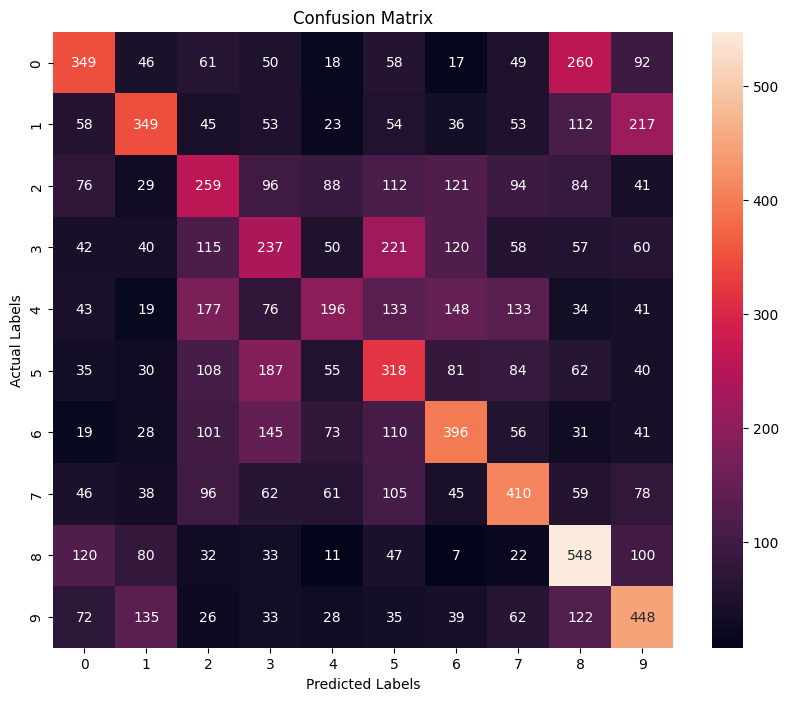

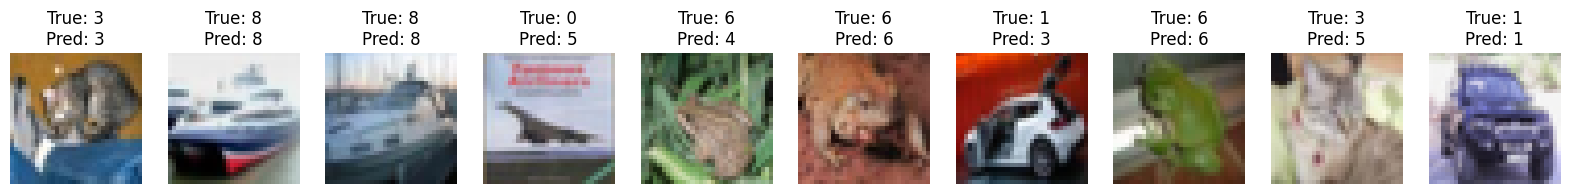

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)

    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h2(x) # /(2 np.pi^(1/4) * np.sqr(2!))
    x = x
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 150

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



313/313 [==============================] - 0s 654us/step


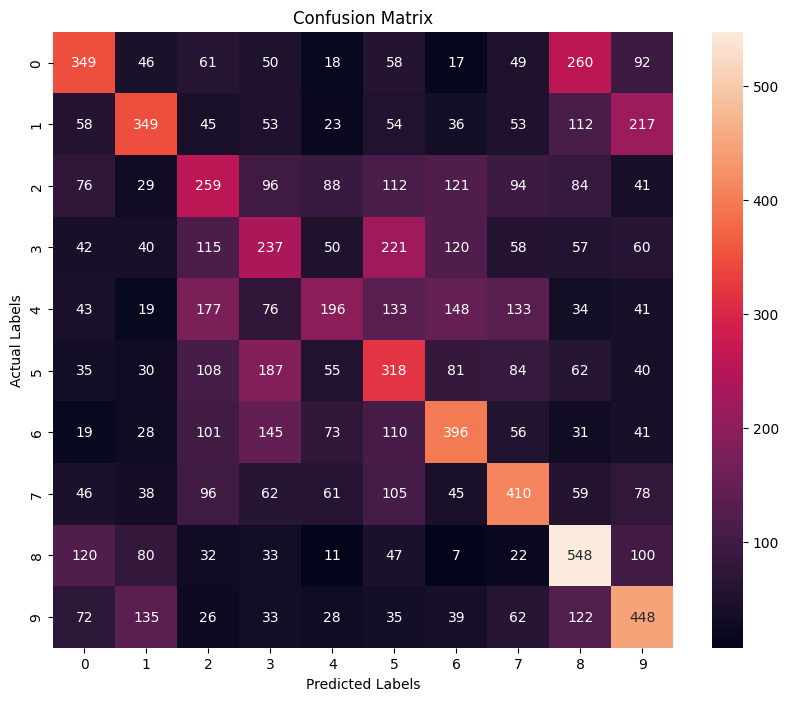

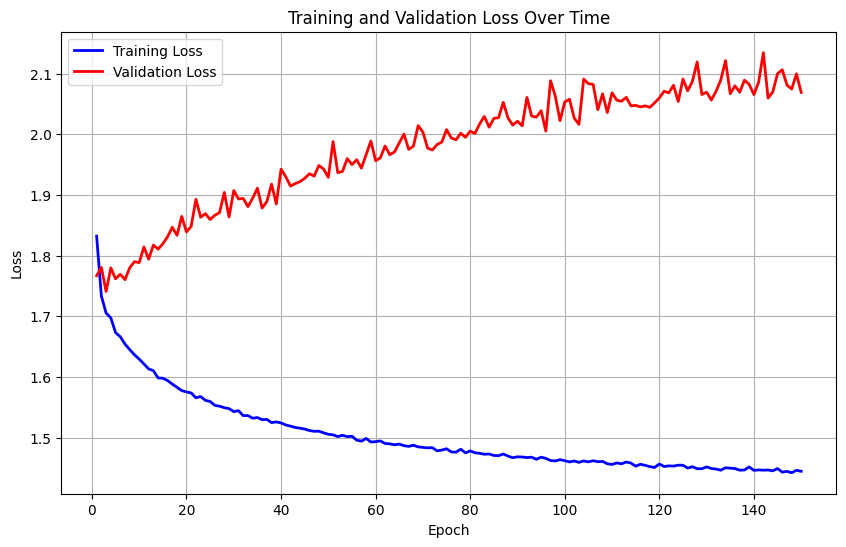

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()


##  MNIST

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 flatten_1 (Flatten)         (None, 43264)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                432650    
                                                                 
Total params: 433290 (1.65 MB)
Trainable params: 433290 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 0.3505 - accuracy: 0.8992 - val_loss: 0.2958 - val_accuracy: 0.9169
Epoch 2/10
93

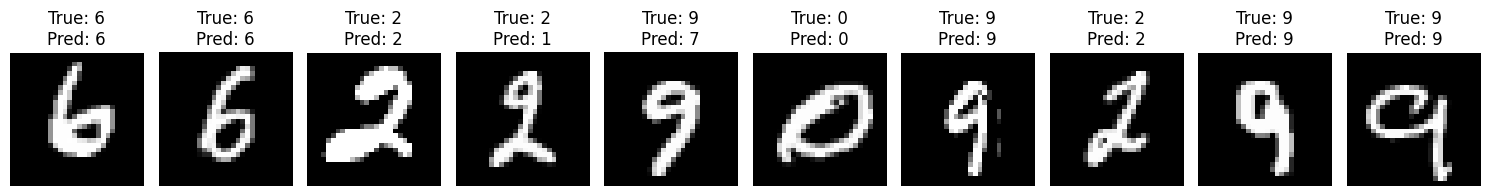

In [3]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)

    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h2(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h3(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h4(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(3, 3))(x)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 128
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 10

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


2024-01-24 13:42:29.032879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 13:42:29.049176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 13:42:29.049361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 10)                432650    
                                                                 
Total params: 433290 (1.65 MB)
Trainable params: 433290 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-01-24 13:42:31.191182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-24 13:42:31.720371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-24 13:42:31.722845: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x210238e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-24 13:42:31.722875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-24 13:42:31.728849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-24 13:42:31.836136: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 4s 2ms/step - loss: 0.3503 - accuracy: 0.8990 - val_loss: 0.2961 - val_accuracy: 0.9170
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2958 - accuracy: 0.9161 - val_loss: 0.2879 - val_accuracy: 0.9232
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2839 - accuracy: 0.9207 - val_loss: 0.2812 - val_accuracy: 0.9223
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2765 - accuracy: 0.9214 - val_loss: 0.2869 - val_accuracy: 0.9230
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2745 - accuracy: 0.9227 - val_loss: 0.2851 - val_accuracy: 0.9208
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2692 - accuracy: 0.9246 - val_loss: 0.2821 - val_accuracy: 0.9238
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 0.2646 - accuracy: 0.9259 - val_loss: 0.2875 - val_accuracy: 0.9213
Epoch 8/10
938/93

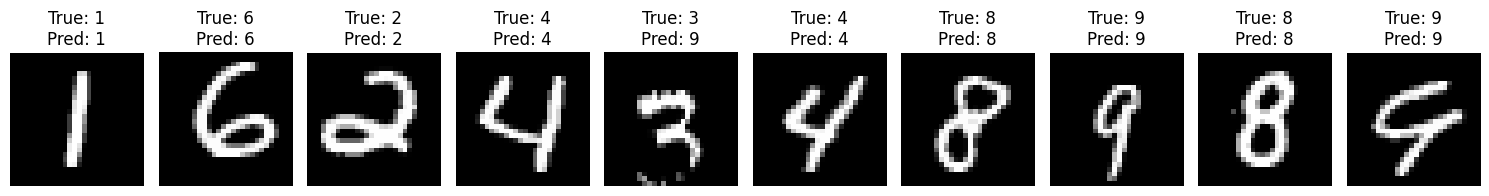

In [3]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)

    x = Conv2D(filters=filters, kernel_size=(3, 3),activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h2(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h3(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h4(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(3, 3))(input_layer)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 128
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 10

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


# Image net Implementation 01/29/2024

In [2]:
import tensorflow as tf

def load_dataset_from_directory(directory, batch_size, img_height, img_width):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False
    )

train_dataset = load_dataset_from_directory(
    '../../ILSVRC2012_img_train/',
    batch_size=32, 
    img_height=224, 
    img_width=224
)


Found 1281167 files belonging to 1000 classes.


2024-01-31 14:36:05.757455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 14:36:05.792946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-31 14:36:05.793193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import os

def load_validation_labels(label_file):
    with open(label_file, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return labels

val_labels = load_validation_labels('../../data/ILSVRC2010_validation_ground_truth.txt')


def load_validation_dataset(image_directory, label_file, batch_size, img_height, img_width):
    labels = load_validation_labels(label_file)
    image_paths = [os.path.join(image_directory, fname) for fname in sorted(os.listdir(image_directory))]

    # Create a dataset of image paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))

    # Load the images
    image_ds = path_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    image_ds = image_ds.map(lambda x: tf.image.resize(x, (img_height, img_width)))

    # Combine images and labels
    val_ds = tf.data.Dataset.zip((image_ds, label_ds))

    # Batch the dataset
    val_ds = val_ds.batch(batch_size)

    return val_ds

val_dataset = load_validation_dataset(
    '../../ILSVRC2010_images_val/val/',
    '../../data/ILSVRC2010_validation_ground_truth.txt',
    batch_size=32,
    img_height=224,
    img_width=224
)


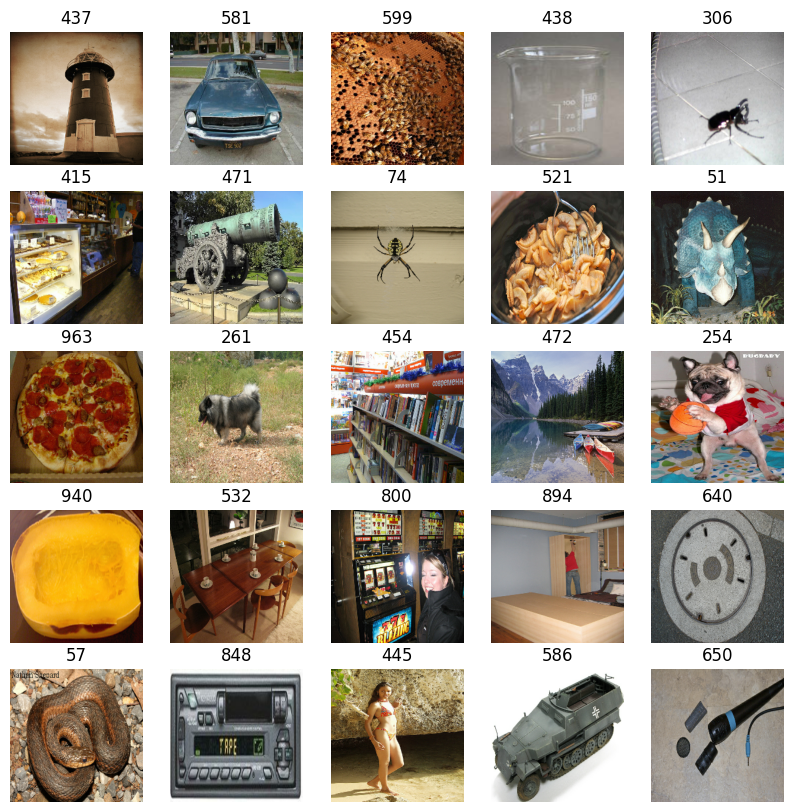

In [3]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
        plt.title(label_batch[n].numpy())
        plt.axis("off")

# Assuming `train_dataset` is your training dataset created using tf.keras.utils.image_dataset_from_directory
for image_batch, label_batch in train_dataset.take(1):
    show_batch(image_batch, label_batch)


In [6]:
def build_model(input_shape, num_classes, filters):
    rank = 7
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer(h1)
    h3 = H3Layer(h1,h2)
    h4 = H4Layer(h2,h3)

    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = h2(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = h3(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (224, 224, 3) # CIFAR-10 images size
num_classes = 1000 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes=num_classes, filters=32)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

batch_size = 32
epochs = 10

history = model_img.fit(train_dataset,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[callback])

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 1000)              1577089000
                                                                 
Total params: 1577089896 (5.88 GB)
Trainable params: 1577089896 (5.88 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


2024-01-31 12:09:11.615853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-31 12:09:12.873709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-31 12:09:12.907378: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe6b3951570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 12:09:12.907423: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-31 12:09:12.928496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-31 12:09:13.120920: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

40037/40037 [==============================] - 4677s 117ms/step - loss: 9765.4668 - accuracy: 0.0050 - val_loss: nan - val_accuracy: 0.0019
Epoch 2/10
 9983/40037 [======>.......................] - ETA: 1:03:49 - loss: 4049.4905 - accuracy: 0.4551

KeyboardInterrupt: 

1/1 [==============================] - 0s 20ms/step


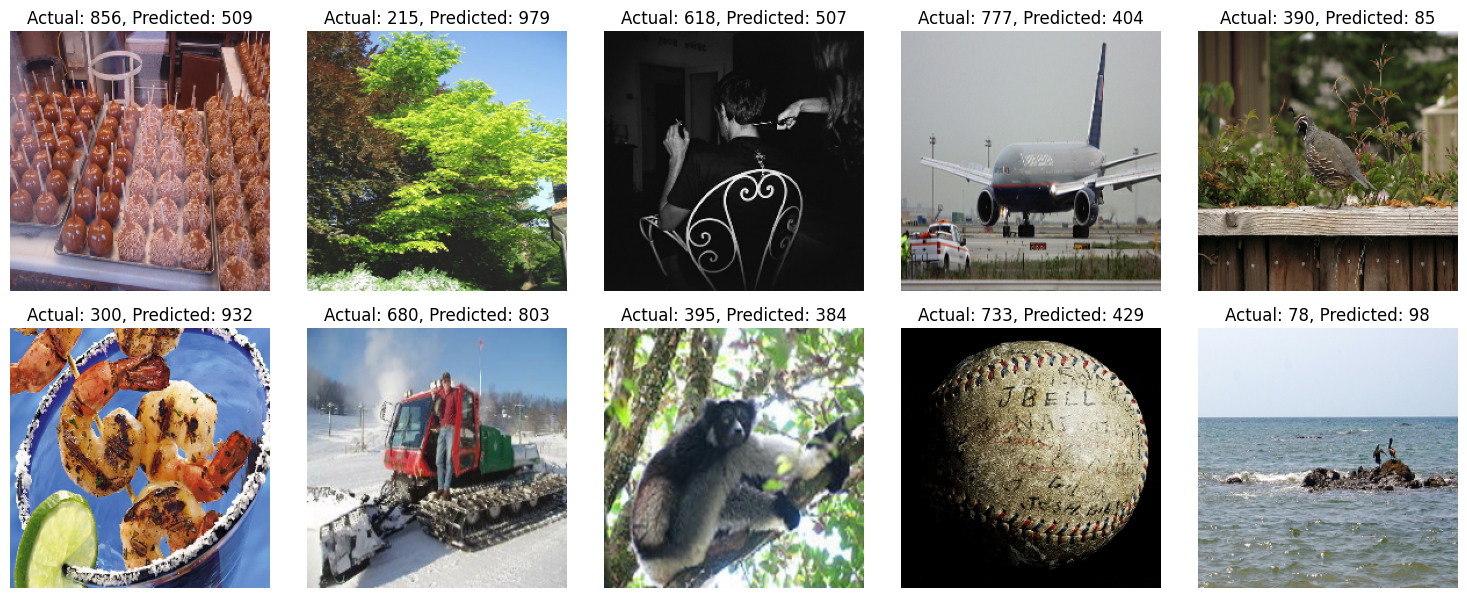

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def display_image_predictions(dataset, model, num_images=10):
    plt.figure(figsize=(15, 15))

    # Retrieve a batch of images from the validation dataset
    for images, labels in dataset.take(1):
        # Randomly select 'num_images' images
        idxs = np.random.choice(images.shape[0], num_images, replace=False)

        for i, idx in enumerate(idxs):
            ax = plt.subplot(5, 5, i + 1)

            # Preprocess the image
            img = images[idx]
            img_array = tf.expand_dims(img, 0)  # Create a batch

            # Make predictions
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])

            # Display the image
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f"Actual: {labels[idx]}, Predicted: {predicted_class}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # We only need one batch

# Test the model with random images from the validation dataset
display_image_predictions(val_dataset, model)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_51 (Ba  (None, 112, 112, 32)         128       ['conv2d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_35 (Activation)  (None, 112, 112, 32)         0         ['batch_normalization_51

2024-01-31 14:49:45.473481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-31 14:49:46.291151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-31 14:49:46.864280: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2588c3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 14:49:46.864310: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-31 14:49:46.870152: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-31 14:49:46.983971: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40037/40037 [==============================] - 3629s 90ms/step - loss: 5.0472 - accuracy: 0.0863 - val_loss: nan - val_accuracy: 0.0020
Epoch 2/10
40037/40037 [==============================] - 3598s 90ms/step - loss: 3.6532 - accuracy: 0.2522 - val_loss: nan - val_accuracy: 0.0023
Epoch 3/10
40037/40037 [==============================] - 3600s 90ms/step - loss: 3.0518 - accuracy: 0.3502 - val_loss: nan - val_accuracy: 0.0023
Epoch 4/10
40037/40037 [==============================] - 3598s 90ms/step - loss: 2.6890 - accuracy: 0.4126 - val_loss: nan - val_accuracy: 0.0026
Epoch 5/10
40037/40037 [==============================] - 3598s 90ms/step - loss: 2.4429 - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.0032
Epoch 6/10
40037/40037 [==============================] - 3600s 90ms/step - loss: 2.2618 - accuracy: 0.4910 - val_loss: nan - val_accuracy: 0.0034
Epoch 7/10
40037/40037 [==============================] - 3572s 89ms/step - loss: 2.1225 - accuracy: 0.5165 - val_loss: nan - val

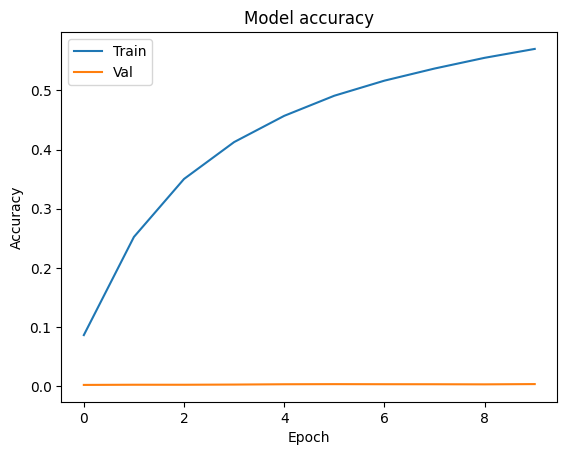

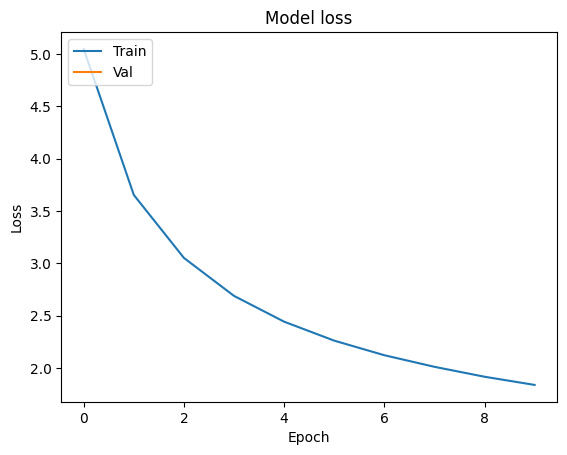

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def swish_activation(x):
    return x * tf.keras.backend.sigmoid(x)

def squeeze_and_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    
    se = layers.GlobalAveragePooling2D()(init)
    se = layers.Reshape(se_shape)(se)
    se = layers.Dense(filters // ratio, activation=swish_activation)(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    
    x = layers.multiply([init, se])
    return x

def MBConvBlock(input_tensor, filters, kernel_size, strides, expand_ratio, se_ratio, activation=swish_activation):
    channel_axis = -1
    input_filters = input_tensor.shape[channel_axis]
    expanded_filters = input_filters * expand_ratio
    
    x = input_tensor
    
    if expand_ratio != 1:
        x = layers.Conv2D(expanded_filters, 1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization(axis=channel_axis)(x)
        x = layers.activation(activation)(x)
        
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(axis=channel_axis)(x)
    x = layers.Activation(activation)(x)
    
    if se_ratio:
        x = squeeze_and_excite_block(x, se_ratio)
    
    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization(axis=channel_axis)(x)
    
    if strides == 1 and input_filters == filters:
        x = layers.Add()([x, input_tensor])
    
    return x

def EfficientNetB0(input_shape=(224, 224, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)
    
    # Stem
    x = layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish_activation)(x)
    
    # MBConv blocks
    x = MBConvBlock(x, filters=16, kernel_size=3, strides=1, expand_ratio=1, se_ratio=None)  # Block 1
    x = MBConvBlock(x, filters=24, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)  # Block 2, repeated 2x
    x = MBConvBlock(x, filters=24, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=40, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)  # Block 3, repeated 2x
    x = MBConvBlock(x, filters=40, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=80, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)  # Block 4, repeated 3x
    x = MBConvBlock(x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=112, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)  # Block 5, repeated 3x
    x = MBConvBlock(x, filters=112, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=112, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=192, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)  # Block 6, repeated 4x
    x = MBConvBlock(x, filters=192, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=192, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=192, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = MBConvBlock(x, filters=320, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)  # Block 7
    # Add more MBConv blocks as per the EfficientNetB0 architecture
    
    # Head
    x = layers.Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish_activation)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Create and compile the model
model = EfficientNetB0()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Model summary
model.summary()

input_shape = (224, 224, 3) # CIFAR-10 images size
epochs = 10

history = model.fit(train_dataset,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[callback])

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


## New arch Passing old H values to updated X

# Not Feed forward any more, it is recurrent

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=9.8023e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (2*x*(h1))-2
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (2 * x * (h2))-(4 * h1)

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (2*x*(h3))-(6*h2)   

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (2*x*(h4))-(8*h3)
    
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-03-18 12:40:52.777255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 12:40:53.264021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-02-07 12:56:40.947502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 12:56:40.965397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-07 12:56:40.965575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 h1_layer (H1Layer)          (None, 32, 32, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['h1_layer[0][0]']            
                                                                                              

2024-02-07 12:56:44.738763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-07 12:56:45.360743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-07 12:56:45.362036: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5c3edb95a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 12:56:45.362049: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-07 12:56:45.365201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-07 12:56:45.461477: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

782/782 [==============================] - 15s 13ms/step - loss: 2.5692 - accuracy: 0.1676 - val_loss: 1.9620 - val_accuracy: 0.3073
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 1.8559 - accuracy: 0.3516 - val_loss: 1.7295 - val_accuracy: 0.3929
Epoch 3/10
782/782 [==============================] - 10s 13ms/step - loss: 1.6743 - accuracy: 0.4126 - val_loss: 1.6075 - val_accuracy: 0.4298
Epoch 4/10
782/782 [==============================] - 10s 13ms/step - loss: 1.5970 - accuracy: 0.4397 - val_loss: 1.6426 - val_accuracy: 0.4101
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 1.5316 - accuracy: 0.4601 - val_loss: 1.5421 - val_accuracy: 0.4578
Epoch 6/10
782/782 [==============================] - 10s 13ms/step - loss: 1.4920 - accuracy: 0.4739 - val_loss: 1.5387 - val_accuracy: 0.4499
Epoch 7/10
782/782 [==============================] - 10s 13ms/step - loss: 1.4476 - accuracy: 0.4873 - val_loss: 1.5218 - val_accuracy: 0.4627
Epo

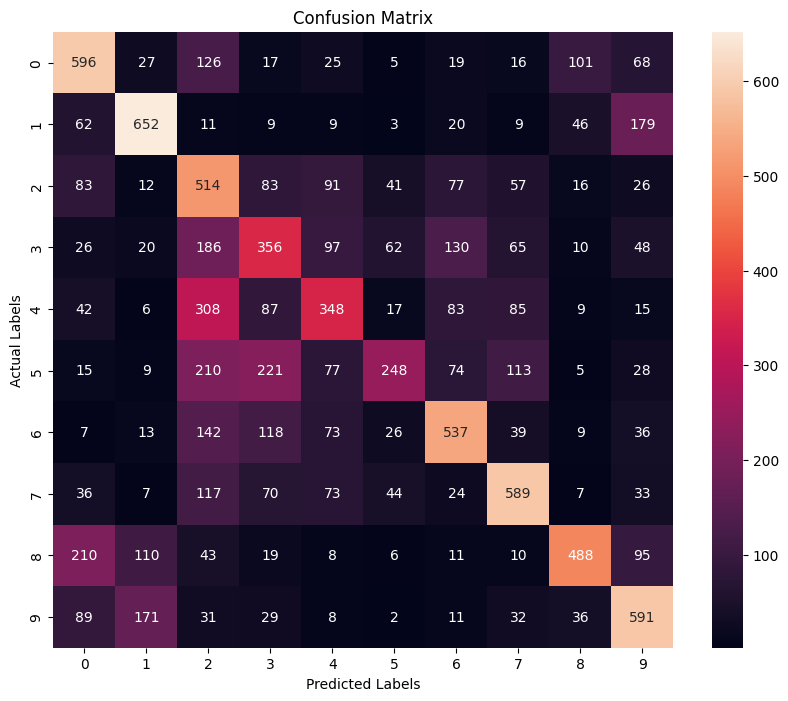

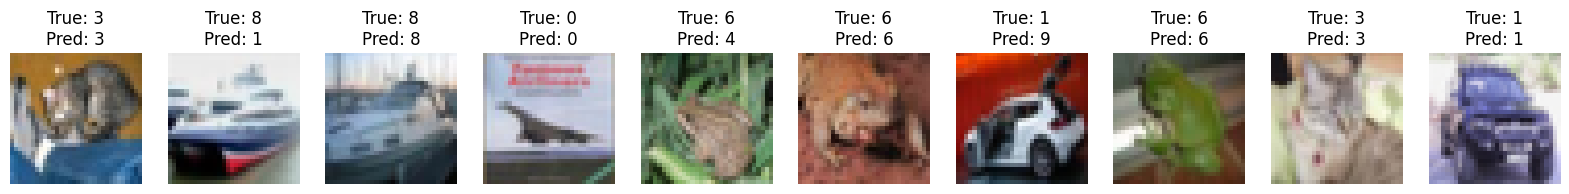

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    #h5 and 6
    #Relu beggining and relu end
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(input_layer)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 10

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



# Added more hermite layers
## H6 was just not good at all.

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)


2024-02-12 14:00:10.710756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:00:10.729630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:00:10.729822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 h1_layer (H1Layer)          (None, 32, 32, 128)          128       ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 128)          147584    ['h1_layer[0][0]']            
                                                                                              

s-bus-pci#L344-L355
2024-02-12 14:00:10.732036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:00:10.732151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 14:00:11.153966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

Epoch 1/15


2024-02-12 14:00:15.000203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-12 14:00:15.808003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-12 14:00:15.810242: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbde0cb95b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-12 14:00:15.810255: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-12 14:00:15.813695: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-12 14:00:15.911875: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

391/391 [==============================] - 28s 59ms/step - loss: 113.5593 - accuracy: 0.1144 - val_loss: 2.2730 - val_accuracy: 0.1502
Epoch 2/15
391/391 [==============================] - 22s 56ms/step - loss: 2.2240 - accuracy: 0.1663 - val_loss: 2.1263 - val_accuracy: 0.2042
Epoch 3/15
391/391 [==============================] - 22s 56ms/step - loss: 2.0087 - accuracy: 0.2709 - val_loss: 1.9359 - val_accuracy: 0.3192
Epoch 4/15
391/391 [==============================] - 22s 56ms/step - loss: 1.8971 - accuracy: 0.3285 - val_loss: 1.8538 - val_accuracy: 0.3457
Epoch 5/15
391/391 [==============================] - 22s 56ms/step - loss: 1.8007 - accuracy: 0.3672 - val_loss: 1.7553 - val_accuracy: 0.3865
Epoch 6/15
391/391 [==============================] - 22s 56ms/step - loss: 1.7440 - accuracy: 0.3889 - val_loss: 1.7533 - val_accuracy: 0.3866
Epoch 7/15
391/391 [==============================] - 22s 56ms/step - loss: 1.7004 - accuracy: 0.4066 - val_loss: 1.6769 - val_accuracy: 0.4087
E

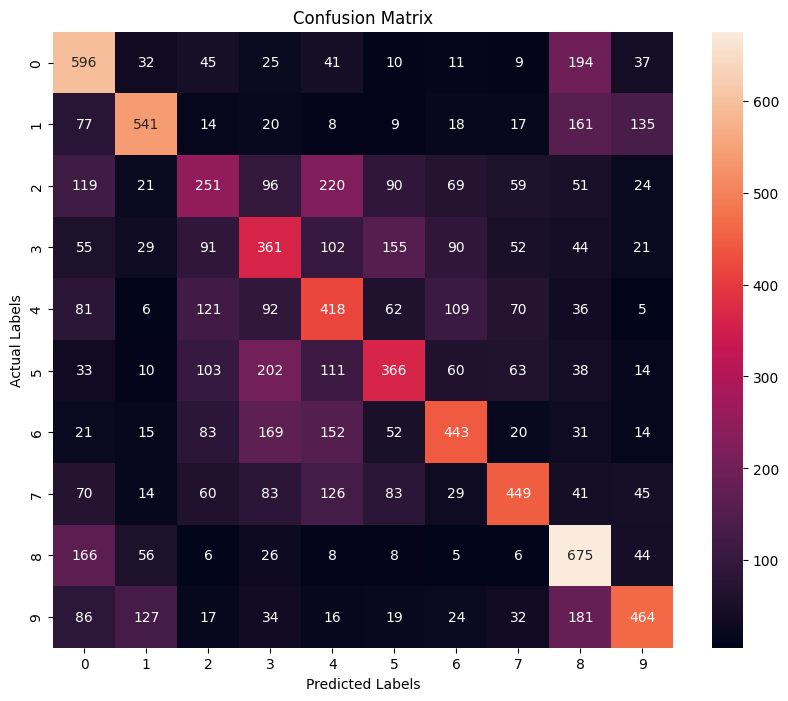

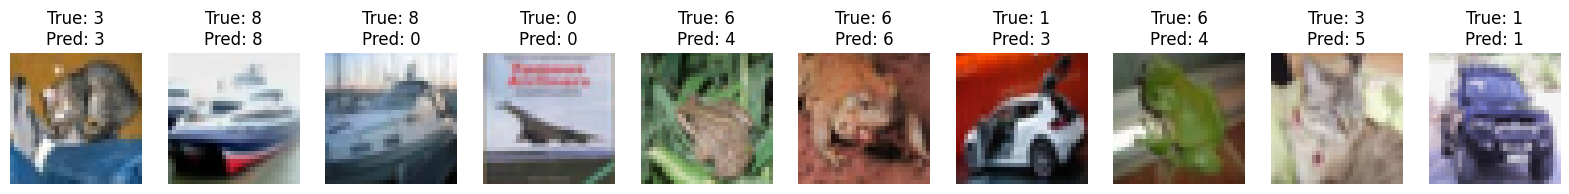

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    #h5 and 6 layers added
    h5 = H5Layer()
    h6 = H6Layer()

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h4 = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h5 = h5(x,x_h3,x_h4)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 128
epochs = 15

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



## Adding max pooling

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)           0         ['conv2d_1[0][0]']            
 g2D)                                                                                             
                                                                                              

2024-02-07 13:17:29.827207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-07 13:17:30.433207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-07 13:17:30.434893: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ff99590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-07 13:17:30.434923: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-07 13:17:30.440207: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-07 13:17:30.545427: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 10s 7ms/step - loss: 2.0951 - accuracy: 0.2678 - val_loss: 1.7116 - val_accuracy: 0.4030
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 1.6370 - accuracy: 0.4248 - val_loss: 1.5811 - val_accuracy: 0.4412
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 1.5374 - accuracy: 0.4588 - val_loss: 1.4943 - val_accuracy: 0.4674
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 1.4593 - accuracy: 0.4810 - val_loss: 1.4284 - val_accuracy: 0.4910
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 1.3696 - accuracy: 0.5134 - val_loss: 1.3520 - val_accuracy: 0.5202
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 1.2984 - accuracy: 0.5423 - val_loss: 1.2895 - val_accuracy: 0.5402
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 1.2547 - accuracy: 0.5561 - val_loss: 1.2679 - val_accuracy: 0.5469
Epoch 8/10
782/7

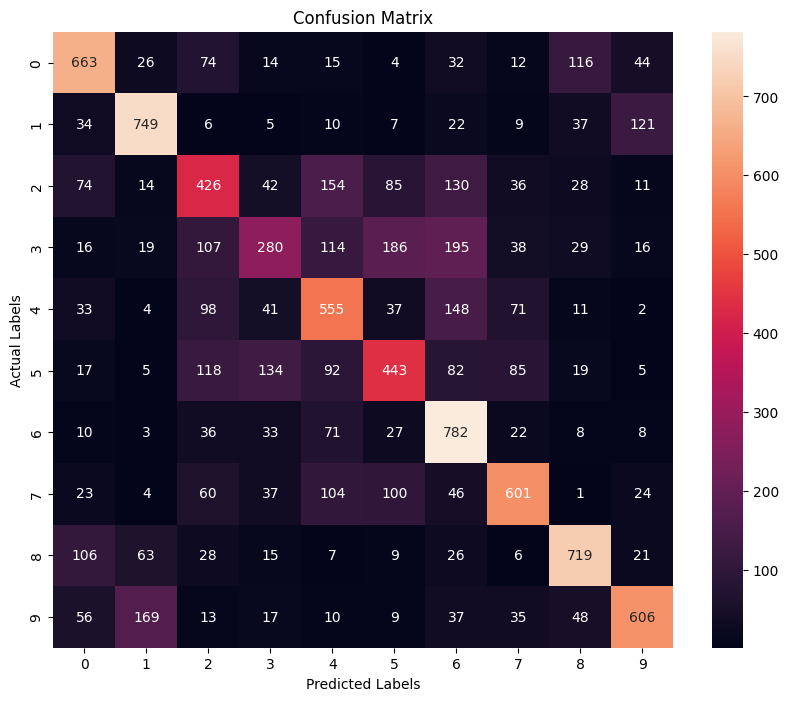

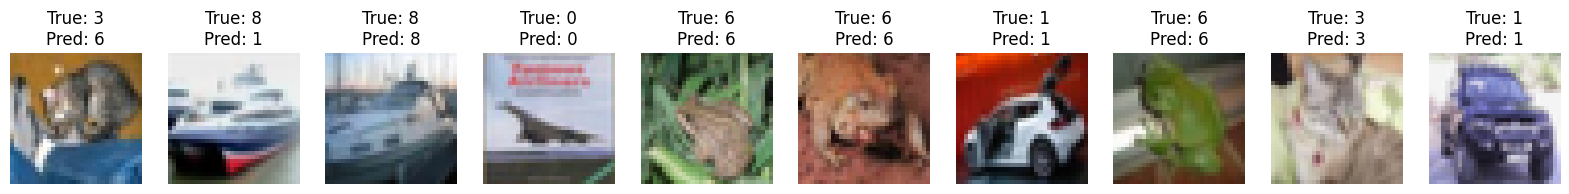

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    
    x = Flatten()(x)

    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 64)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 10

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



# Adding relu layers

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')
# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

# Printing the shape of the dataset to confirm
# print("Training data shape:", x_train.shape, y_train.shape)
# print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 5
    input_layer = Input(shape=input_shape)
    x = input_layer
    weight_decay = 0.001

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)

    #x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 256)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_img.fit(data_generator.flow(X_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_test
y_true = y_valid
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_img.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)
# # Plotting a confusion matrix
# plt.figure(figsize=(10, 8))
# cm = confusion_matrix(y_true_labels, y_pred_labels)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.show()

# # Displaying a few images with their predictions
# num_samples = 10  # Number of samples to display
# fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

# for i, ax in enumerate(axes):
#     ax.imshow(X_test[i])  # Show the image
#     ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
#     ax.axis('off')

# plt.show()
#897418
#227530
#225930



Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


2024-02-21 14:46:20.762504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 14:46:20.780597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 14:46:20.780784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 32)           9248      ['batch_normalization[0][0

2024-02-21 14:46:23.553562: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 14:46:24.576063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-21 14:46:25.251918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-21 14:46:25.253085: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f0c5000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 14:46:25.253119: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 14:46:25.259194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabl

704/704 - 28s - loss: 6.2461 - accuracy: 0.2670 - val_loss: 1.8455 - val_accuracy: 0.4178 - 28s/epoch - 39ms/step
Epoch 2/50
704/704 - 20s - loss: 1.7195 - accuracy: 0.4734 - val_loss: 1.4590 - val_accuracy: 0.5642 - 20s/epoch - 29ms/step
Epoch 3/50
704/704 - 20s - loss: 1.4749 - accuracy: 0.5640 - val_loss: 1.6957 - val_accuracy: 0.5770 - 20s/epoch - 29ms/step
Epoch 4/50
704/704 - 20s - loss: 1.3151 - accuracy: 0.6287 - val_loss: 1.2130 - val_accuracy: 0.6762 - 20s/epoch - 29ms/step
Epoch 5/50
704/704 - 20s - loss: 1.2224 - accuracy: 0.6624 - val_loss: 1.1811 - val_accuracy: 0.6908 - 20s/epoch - 29ms/step
Epoch 6/50
704/704 - 20s - loss: 1.1647 - accuracy: 0.6911 - val_loss: 1.0568 - val_accuracy: 0.7366 - 20s/epoch - 29ms/step
Epoch 7/50
704/704 - 20s - loss: 1.1130 - accuracy: 0.7107 - val_loss: 1.0216 - val_accuracy: 0.7500 - 20s/epoch - 29ms/step
Epoch 8/50
704/704 - 20s - loss: 1.0965 - accuracy: 0.7196 - val_loss: 0.9728 - val_accuracy: 0.7704 - 20s/epoch - 29ms/step
Epoch 9/50


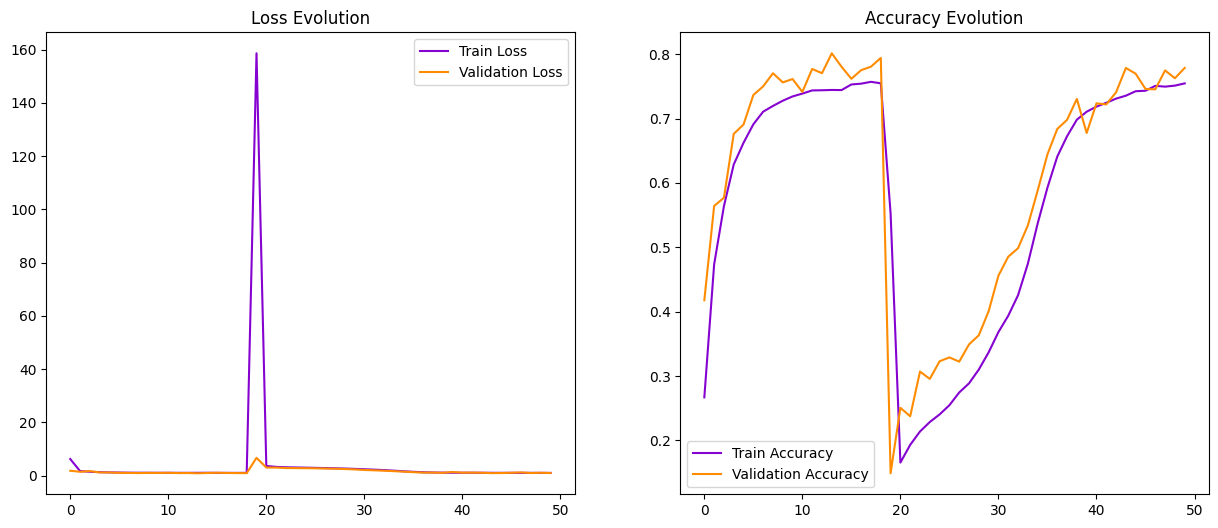

In [3]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

## V2

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')
# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

# Printing the shape of the dataset to confirm
# print("Training data shape:", x_train.shape, y_train.shape)
# print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer
    weight_decay = 0.001

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()

    x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)

    #x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_img.fit(data_generator.flow(X_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_valid, y_valid),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_test
y_true = y_valid
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_img.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)
# # Plotting a confusion matrix
# plt.figure(figsize=(10, 8))
# cm = confusion_matrix(y_true_labels, y_pred_labels)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('Confusion Matrix')
# plt.ylabel('Actual Labels')
# plt.xlabel('Predicted Labels')
# plt.show()

# # Displaying a few images with their predictions
# num_samples = 10  # Number of samples to display
# fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

# for i, ax in enumerate(axes):
#     ax.imshow(X_test[i])  # Show the image
#     ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
#     ax.axis('off')

# plt.show()
#897418
#227530
#225930



Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


2024-02-21 13:50:40.587065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 13:50:40.604553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 13:50:40.604741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 16)           2320      ['batch_normalization[0][0

2024-02-21 13:50:43.323771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 13:50:44.365364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-21 13:50:45.074133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-21 13:50:45.075067: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f231a96a6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 13:50:45.075079: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 13:50:45.078215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

704/704 - 28s - loss: 1.9626 - accuracy: 0.3124 - val_loss: 1.6420 - val_accuracy: 0.4470 - 28s/epoch - 40ms/step
Epoch 2/50
704/704 - 21s - loss: 1.4535 - accuracy: 0.5081 - val_loss: 1.2173 - val_accuracy: 0.6064 - 21s/epoch - 29ms/step
Epoch 3/50
704/704 - 20s - loss: 1.3048 - accuracy: 0.5723 - val_loss: 1.1852 - val_accuracy: 0.6256 - 20s/epoch - 29ms/step
Epoch 4/50
704/704 - 21s - loss: 1.2181 - accuracy: 0.6093 - val_loss: 1.2577 - val_accuracy: 0.6030 - 21s/epoch - 29ms/step
Epoch 5/50
704/704 - 20s - loss: 1.1758 - accuracy: 0.6295 - val_loss: 1.4157 - val_accuracy: 0.6182 - 20s/epoch - 29ms/step
Epoch 6/50
704/704 - 21s - loss: 1.1326 - accuracy: 0.6496 - val_loss: 1.0205 - val_accuracy: 0.6954 - 21s/epoch - 29ms/step
Epoch 7/50
704/704 - 21s - loss: 1.1003 - accuracy: 0.6666 - val_loss: 1.0949 - val_accuracy: 0.6764 - 21s/epoch - 29ms/step
Epoch 8/50
704/704 - 20s - loss: 1.0803 - accuracy: 0.6748 - val_loss: 1.0168 - val_accuracy: 0.7066 - 20s/epoch - 29ms/step
Epoch 9/50


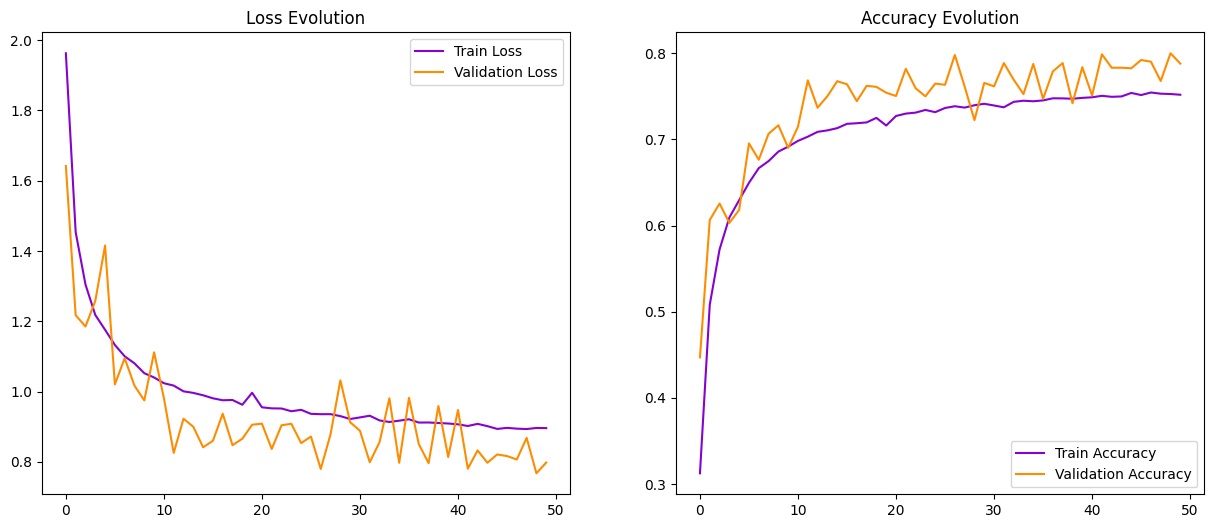

In [3]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

# Image net implementation 02/14/2024

In [3]:
import tensorflow as tf

def load_dataset_from_directory(directory, batch_size, img_height, img_width):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=(img_height, img_width),
        shuffle=True,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation='bilinear',
        follow_links=False
    )

train_dataset = load_dataset_from_directory(
    '../../ILSVRC2012_img_train/',
    batch_size=32, 
    img_height=224, 
    img_width=224
)

import os

def load_validation_labels(label_file):
    with open(label_file, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return labels

val_labels = load_validation_labels('../../data/ILSVRC2010_validation_ground_truth.txt')


def load_validation_dataset(image_directory, label_file, batch_size, img_height, img_width):
    labels = load_validation_labels(label_file)
    image_paths = [os.path.join(image_directory, fname) for fname in sorted(os.listdir(image_directory))]

    # Create a dataset of image paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.int64))

    # Load the images
    image_ds = path_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    image_ds = image_ds.map(lambda x: tf.image.resize(x, (img_height, img_width)))

    # Combine images and labels
    val_ds = tf.data.Dataset.zip((image_ds, label_ds))

    # Batch the dataset
    val_ds = val_ds.batch(batch_size)

    return val_ds

val_dataset = load_validation_dataset(
    '../../ILSVRC2010_images_val/val/',
    '../../data/ILSVRC2010_validation_ground_truth.txt',
    batch_size=32,
    img_height=224,
    img_width=224
)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer
    weight_decay = 0.001

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = MaxPooling2D((2,2))(x)
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = MaxPooling2D((2,2))(x)
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # # x = MaxPooling2D((2,2))(x)
    # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    # x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)

    #x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 



Found 1281167 files belonging to 1000 classes.


2024-02-20 15:08:14.500843: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 15:08:14.518637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-20 15:08:14.518825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:

input_shape = (224, 224, 3) # Image net images size
num_classes = 1000 # Number of classes in Imagenet
model_img = build_model(input_shape, num_classes=num_classes, filters=128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

batch_size = 64
epochs = 40

history = model_img.fit(train_dataset,
                    epochs=epochs,
                    verbose=2,
                    validation_data=val_dataset,
                    callbacks=[callback])

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

def display_image_predictions(dataset, model, num_images=10):
    plt.figure(figsize=(15, 15))

    # Retrieve a batch of images from the validation dataset
    for images, labels in dataset.take(1):
        # Randomly select 'num_images' images
        idxs = np.random.choice(images.shape[0], num_images, replace=False)

        for i, idx in enumerate(idxs):
            ax = plt.subplot(5, 5, i + 1)

            # Preprocess the image
            img = images[idx]
            img_array = tf.expand_dims(img, 0)  # Create a batch

            # Make predictions
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])

            # Display the image
            plt.imshow(img.numpy().astype("uint8"))
            plt.title(f"Actual: {labels[idx]}, Predicted: {predicted_class}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()
        break  # We only need one batch

# Test the model with random images from the validation dataset
display_image_predictions(val_dataset, model_img)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         9248      ['batch_normalization[0][0

2024-02-20 15:08:23.092575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-20 15:08:24.227114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-20 15:08:25.048109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-20 15:08:25.051205: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f46fbe9a3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 15:08:25.051218: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-20 15:08:25.054295: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

40037/40037 - 2799s - loss: 18.1901 - accuracy: 0.0299 - val_loss: nan - val_accuracy: 0.0013 - 2799s/epoch - 70ms/step
Epoch 2/40
40037/40037 - 2793s - loss: 8.5173 - accuracy: 0.0599 - val_loss: nan - val_accuracy: 0.0012 - 2793s/epoch - 70ms/step
Epoch 3/40
40037/40037 - 2780s - loss: 6.1626 - accuracy: 0.0875 - val_loss: nan - val_accuracy: 0.0016 - 2780s/epoch - 69ms/step
Epoch 4/40
40037/40037 - 2763s - loss: 6.9786 - accuracy: 0.1045 - val_loss: nan - val_accuracy: 0.0014 - 2763s/epoch - 69ms/step
Epoch 5/40
40037/40037 - 2761s - loss: 9.0939 - accuracy: 0.1137 - val_loss: nan - val_accuracy: 0.0015 - 2761s/epoch - 69ms/step
Epoch 6/40
40037/40037 - 2761s - loss: 7.8345 - accuracy: 0.1152 - val_loss: nan - val_accuracy: 0.0018 - 2761s/epoch - 69ms/step
Epoch 7/40
40037/40037 - 2762s - loss: 5.5858 - accuracy: 0.1404 - val_loss: nan - val_accuracy: 0.0016 - 2762s/epoch - 69ms/step
Epoch 8/40
40037/40037 - 2760s - loss: 5.7045 - accuracy: 0.1505 - val_loss: nan - val_accuracy: 0.0

KeyboardInterrupt: 

# Implementation of Dense Layers Hermite

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')
# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

# Data augmentation
data_generator = ImageDataGenerator(
    # Rotate images randomly by up to 15 degrees
    rotation_range=15,
    
    # Shift images horizontally by up to 12% of their width
    width_shift_range=0.12,
    
    # Shift images vertically by up to 12% of their height
    height_shift_range=0.12,
    
    # Randomly flip images horizontally
    horizontal_flip=True,
    
    # Zoom images in by up to 10%
    zoom_range=0.1,
    
    # Change brightness by up to 10%
    brightness_range=[0.9,1.1],

    # Shear intensity (shear angle in counter-clockwise direction in degrees)
    shear_range=10,
    
    # Channel shift intensity
    channel_shift_range=0.1,
)

# Printing the shape of the dataset to confirm
# print("Training data shape:", x_train.shape, y_train.shape)
# print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 4
    input_layer = Input(shape=input_shape)
    x = input_layer
    weight_decay = 0.01

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(10)(x)
    x = x_h1 = h1(x)
    # x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    # x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    # x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    # x = Dense(64)(x)
    x = TensorDecompositionLayer(rank)(x)
    # x = Dense(64)(x)
    #x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_test
y_true = y_test
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_img.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)


Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


2024-02-21 13:36:54.893811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 13:36:54.911643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-21 13:36:54.911833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 32)           9248      ['batch_normalization[0][0

2024-02-21 13:36:58.187578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 13:36:59.148102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-21 13:36:59.760316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-21 13:36:59.761949: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4622c6a920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 13:36:59.761973: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-21 13:36:59.767334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] di

704/704 [==============================] - 13s 9ms/step - loss: 2.2451 - accuracy: 0.2489 - val_loss: 2.2999 - val_accuracy: 0.2238
Epoch 2/50
704/704 [==============================] - 6s 8ms/step - loss: 1.8395 - accuracy: 0.3719 - val_loss: 2.2853 - val_accuracy: 0.2800
Epoch 3/50
704/704 [==============================] - 6s 8ms/step - loss: 1.7723 - accuracy: 0.4210 - val_loss: 1.8681 - val_accuracy: 0.4086
Epoch 4/50
704/704 [==============================] - 6s 8ms/step - loss: 1.7016 - accuracy: 0.4951 - val_loss: 1.6893 - val_accuracy: 0.5224
Epoch 5/50
704/704 [==============================] - 6s 8ms/step - loss: 1.6295 - accuracy: 0.5587 - val_loss: 1.6875 - val_accuracy: 0.5416
Epoch 6/50
704/704 [==============================] - 6s 8ms/step - loss: 1.5552 - accuracy: 0.5959 - val_loss: 1.6842 - val_accuracy: 0.5522
Epoch 7/50
704/704 [==============================] - 6s 8ms/step - loss: 1.4795 - accuracy: 0.6272 - val_loss: 1.6797 - val_accuracy: 0.5750
Epoch 8/50
704/7

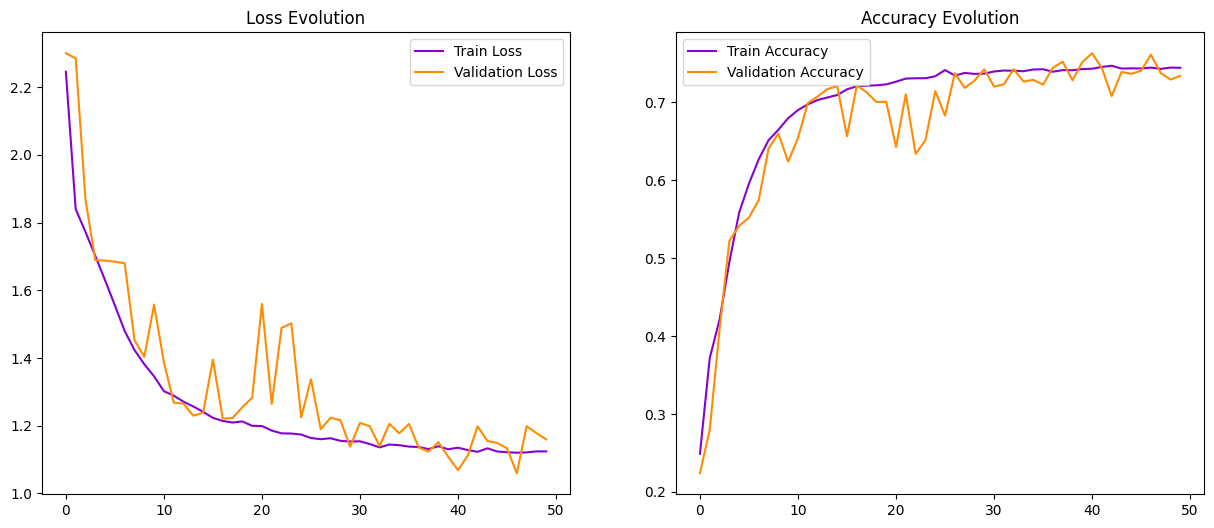

In [3]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

# Test Online implementation


In [4]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())

# Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_9 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

# Making hermite blocks

Training data shape: (50000, 32, 32, 3) (50000, 10)
Test data shape: (10000, 32, 32, 3) (10000, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 128)          3584      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 128)          0         ['conv2d_13[0][0]']           
 g2D)                                                                                             
                                                                                            

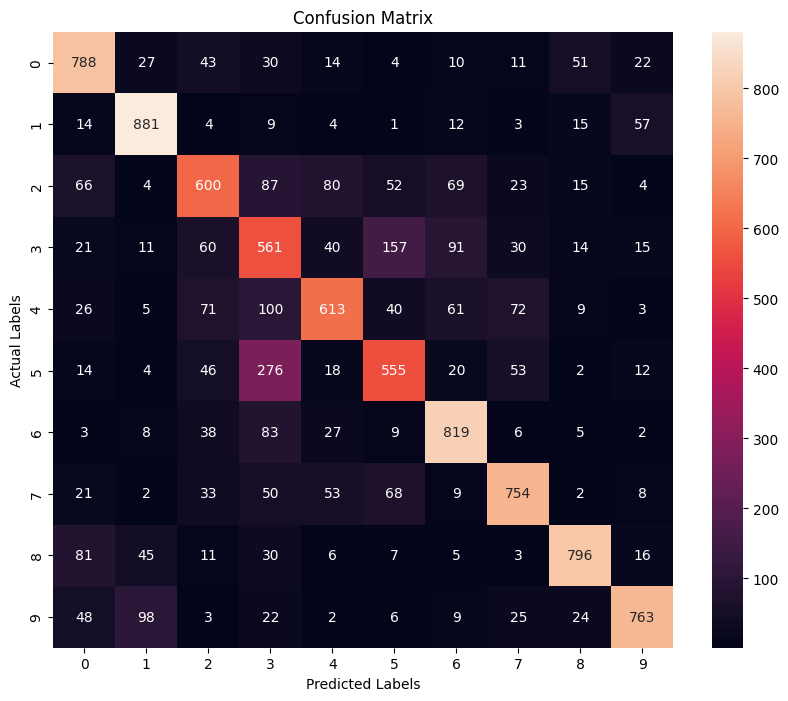

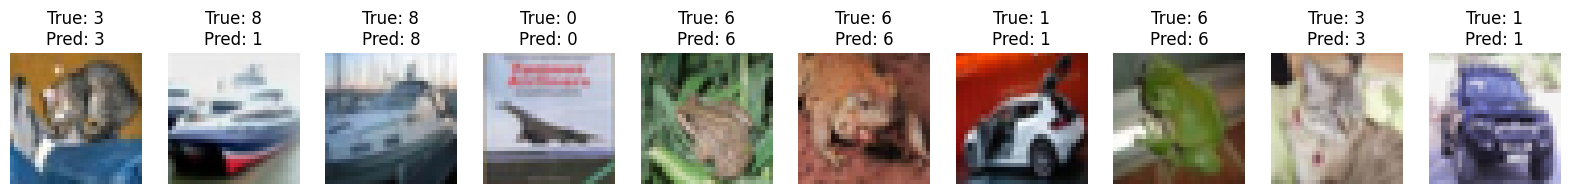

In [5]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
X_train, X_val = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train, y_val = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Printing the shape of the dataset to confirm
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    #Hermite Block 1
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = x_h1 = h1(x)
    x = x_h2 = h2(x,x_h1)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = h4(x,x_h2, x_h3)
    x = TensorDecompositionLayer(rank)(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = Flatten()(x)
    # x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (32, 32, 3) # CIFAR-10 images size
num_classes = 10 # Number of classes in CIFAR-10
model_img = build_model(input_shape, num_classes, 128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


batch_size = 64
epochs = 10

history = model_img.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_val
y_true = y_val
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting a confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Displaying a few images with their predictions
num_samples = 10  # Number of samples to display
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show the image
    ax.set_title(f"True: {y_true_labels[i]}\nPred: {y_pred_labels[i]}")
    ax.axis('off')

plt.show()



# Test for stanford_dogs

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the stanford_dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,  # Load the dataset in a (image, label) format
    with_info=True  # Get metadata of the dataset
)

# Preprocess the dataset
def preprocess_images(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = tf.keras.applications.efficientnet.preprocess_input(image)  # EfficientNet specific preprocessing
    return image, label

# Apply preprocessing to the datasets
ds_train = ds_train.map(preprocess_images).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_images).batch(32).prefetch(tf.data.AUTOTUNE)

# print('Train Images Shape:      ', ds_train.shape)
# print('Train Labels Shape:      ', y_train.shape)

# print('\nValidation Images Shape: ', X_valid.shape)
# print('Validation Labels Shape: ', y_valid.shape)

# print('\nTest Images Shape:       ', ds_test.shape)
# print('Test Labels Shape:       ', y_test.shape)


def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer
    weight_decay = 0.001

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()

    x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.2)(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = h4(x,x_h2, x_h3)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation=None)(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)

    #x = Dense(128, activation='relu')(x)  # Increase the number of units
    # x = Dense(64, activation='relu')(x)  # Add more dense layers as needed
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (224, 224, 3) # Stanford dogs images size
num_classes = ds_info.features['label'].num_classes # Number of classes in Stanford dogs
model_img = build_model(input_shape, num_classes, 128)
model_img.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
model_img.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])


batch_size = 64
epochs = 50

history = model_img.fit(ds_train, epochs=50,verbose=2, validation_data=ds_test,callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = model_img.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

X_test = X_test
y_true = y_valid
y_pred = model_img.predict(X_test)

# Assuming y_true and y_pred are already one-hot encoded, convert them back to class labels
y_true_labels = np.argmax(y_true, axis=1)
y_pred = model_img.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model_img.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 224, 224, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 224, 224, 16)         64        ['conv2d_12[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv2d_13 (Conv2D)          (None, 224, 224, 16)         2320      ['batch_normalization_6[

2024-03-18 12:41:41.638593: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-18 12:41:42.857112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-18 12:41:43.635768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-18 12:41:43.638351: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd5df6a5670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-18 12:41:43.638363: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-03-18 12:41:43.641527: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255

375/375 - 29s - loss: 9.9436 - accuracy: 0.0091 - val_loss: 4.9952 - val_accuracy: 0.0115 - 29s/epoch - 77ms/step
Epoch 2/50
375/375 - 20s - loss: 4.9241 - accuracy: 0.0099 - val_loss: 4.8692 - val_accuracy: 0.0079 - 20s/epoch - 54ms/step
Epoch 3/50
375/375 - 20s - loss: 4.8102 - accuracy: 0.0191 - val_loss: 4.9197 - val_accuracy: 0.0191 - 20s/epoch - 54ms/step
Epoch 4/50
375/375 - 21s - loss: 4.5855 - accuracy: 0.0383 - val_loss: 4.9375 - val_accuracy: 0.0328 - 21s/epoch - 55ms/step
Epoch 5/50
375/375 - 21s - loss: 4.3547 - accuracy: 0.0731 - val_loss: 5.1062 - val_accuracy: 0.0350 - 21s/epoch - 55ms/step
Epoch 6/50
375/375 - 21s - loss: 4.0251 - accuracy: 0.1220 - val_loss: 5.4736 - val_accuracy: 0.0420 - 21s/epoch - 55ms/step
Epoch 7/50
375/375 - 20s - loss: 3.5141 - accuracy: 0.2023 - val_loss: 5.5909 - val_accuracy: 0.0382 - 20s/epoch - 55ms/step
Epoch 8/50
375/375 - 20s - loss: 2.9769 - accuracy: 0.3060 - val_loss: 5.9244 - val_accuracy: 0.0371 - 20s/epoch - 55ms/step
Epoch 9/50


NameError: name 'X_valid' is not defined